# Импорт библиотек

In [1]:
%%capture
import os
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web

!pip install statsmodels==0.12.2
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

!pip install sktime==0.6.1
!pip install pmdarima==1.8.2
import lightgbm as lgb
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (TransformedTargetForecaster,
                                        make_reduction)
from sktime.forecasting.model_selection import (ExpandingWindowSplitter,
                                                ForecastingGridSearchCV)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

sns.set()
plt.style.use('bmh')

# Sunspots датасет

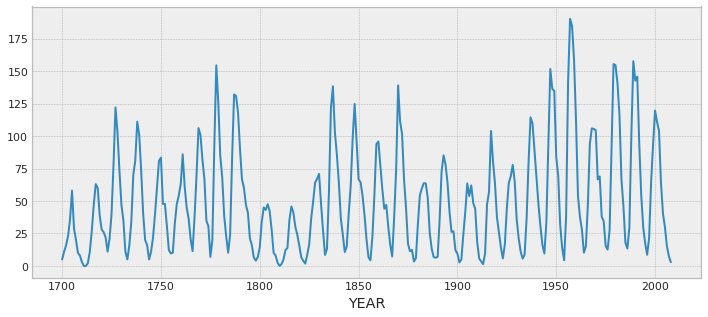

In [2]:
data = sm.datasets.sunspots.load_pandas()
ts_dd = data.data.set_index("YEAR").SUNACTIVITY

ts_dd.plot(figsize=(12, 5))
plt.show()

In [3]:
def tsplot(y, lags=None, figsize=(12, 7)):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)
           
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    p_value = sm.tsa.stattools.adfuller(y)[1]
    ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()

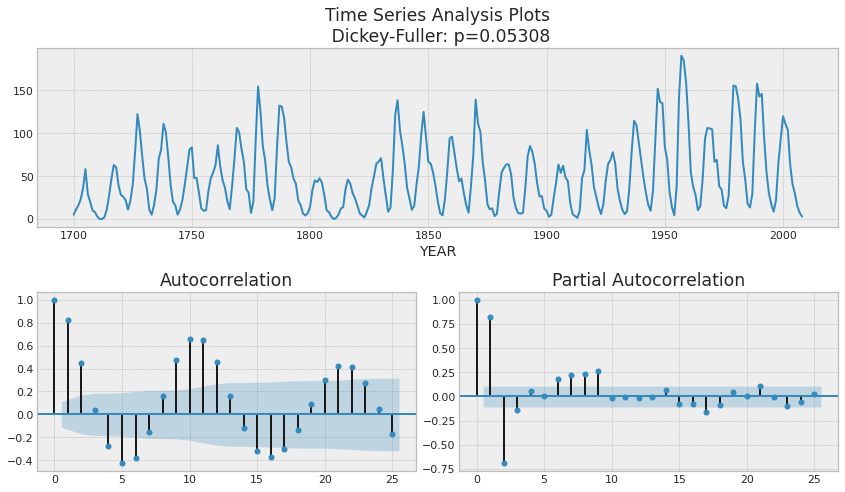

In [4]:
tsplot(ts_dd)

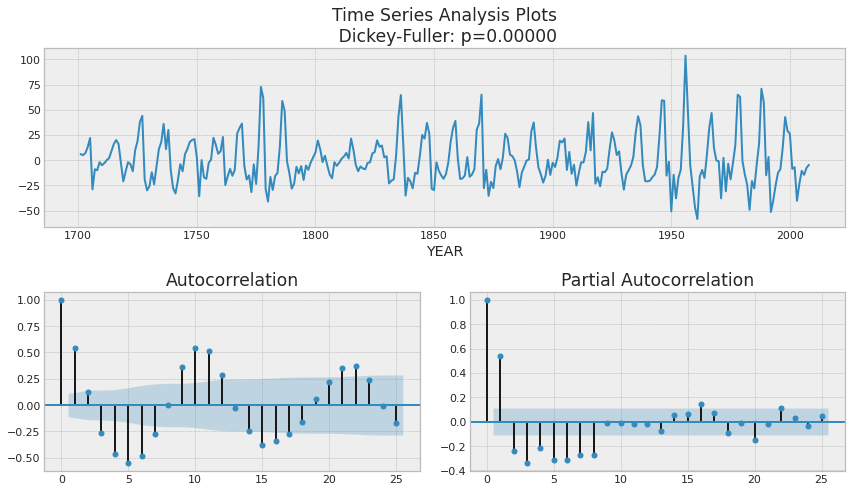

In [5]:
ts_dd_diff = (ts_dd - ts_dd.shift(1)).dropna()
tsplot(ts_dd_diff)

In [14]:
test_len = int(len(ts_dd_diff) * 0.2)
sun_train, sun_test = ts_dd_diff.iloc[:-test_len], ts_dd_diff.iloc[-test_len:]

In [20]:
sun_train.index = sun_train.index.astype(int)
sun_test.index = sun_test.index.astype(int)

In [8]:
def plot_forecast(series_train, series_test, forecast, forecast_int=None):

    mae = mean_absolute_error(series_test, forecast)
    mape = mean_absolute_percentage_error(series_test, forecast)

    plt.figure(figsize=(12, 6))
    plt.title(f"MAE: {mae:.2f}, MAPE: {mape:.3f}", size=18)
    series_train.plot(label="train", color="b")
    series_test.plot(label="test", color="g")
    forecast.index = series_test.index
    forecast.plot(label="forecast", color="r")
    if forecast_int is not None:
        plt.fill_between(
            series_test.index,
            forecast_int["lower"],
            forecast_int["upper"],
            alpha=0.2,
            color="dimgray",
        )
    plt.legend(prop={"size": 16})
    plt.show()

    return mae, mape

best params: {'window_length': 25}


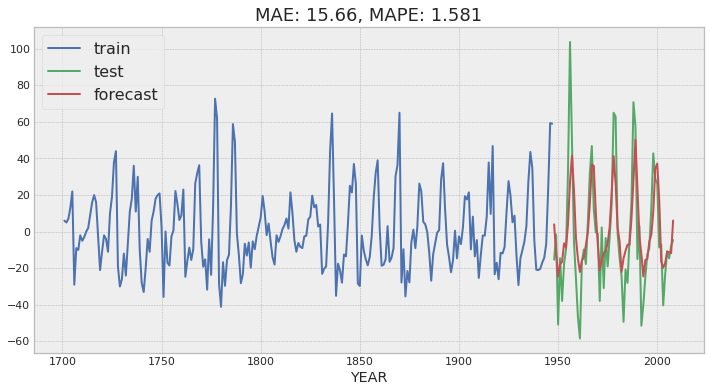

In [22]:
def create_forecaster():

    regressor = lgb.LGBMRegressor()
    forecaster = make_reduction(regressor, window_length=5, strategy="recursive")

    return forecaster


def grid_serch_forecaster(train, test, forecaster, param_grid):

    cv = ExpandingWindowSplitter(initial_window=int(len(train) * 0.7))
    gscv = ForecastingGridSearchCV(
        forecaster, strategy="refit", cv=cv, param_grid=param_grid
    )
    gscv.fit(train)
    print(f"best params: {gscv.best_params_}")

    fh = np.arange(len(test)) + 1
    y_pred = gscv.predict(fh=fh)
    mae, mape = plot_forecast(train, test, y_pred)

    return mae, mape


param_grid = {
    "window_length": [5, 10, 15, 20, 25, 30] 
}
forecaster = create_forecaster()
sun_lgb_mae, sun_lgb_mape = grid_serch_forecaster(
    sun_train, sun_test, forecaster, param_grid
)